(93.79419916500854, 6.205800834991455)

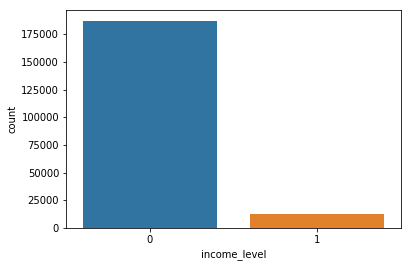

In [27]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import stats
import warnings
warnings.filterwarnings("ignore")
import numpy as np
from sklearn.ensemble import RandomForestRegressor

# Reading data
train = pd.read_csv(r'D:\Asha\Imp\ML\Census_Income\train.csv')
test = pd.read_csv(r'D:\Asha\Imp\ML\Census_Income\test.csv')

# Taking a copy of original data
train_original = train.copy()
test_original = test.copy()

# Checking the data size
#train.info()
# 199523 rows & 41 columns

#train['income_level'].unique() , test['income_level'].unique()
# Encoding Target/Dependent variable as the values are not same in train & test data sets.
train['income_level'] = train['income_level'].map({50000:1,-50000:0})
test['income_level'] = test['income_level'].replace(['-50000', ' 50000+.'],[0,1])

# Checking the distribution of outcome variable.
sns.countplot('income_level',data=train)
# This dataset is imbalanced. Getting the percentage of >50000 & <50000 categories
cnt_less = len(train[train['income_level'] == 0])
cnt_more = len(train[train['income_level'] == 1])
percent_less = cnt_less/(cnt_less+cnt_more)*100
percent_more = cnt_more/(cnt_less+cnt_more)*100
percent_less ,percent_more
# % of people having <50000 income is 93.79% and % of people having >50000 income is 6.21%

In [2]:
# Separating Numerical & Categorical columns for analysis. This will help in analysis.
train_cat = train.iloc[:,np.r_[1,4,6:16,19:29,30:35,36]]
train_num = train.iloc[:,np.r_[0,2:4,5,16:19,29,35,37:41]]

test_cat = test.iloc[:,np.r_[1,4,6:16,19:29,30:35,36]]
test_num = test.iloc[:,np.r_[0,2:4,5,16:19,29,35,37:41]]

In [3]:
# Checking for missing values on Numerical data set
m,n = train_num.isnull().sum() , test_num.isnull().sum()
# There are no missing values in train_num & test_num data sets. Checking for Variance
#train_num.var()
# There are no variables with significantly less Variance. Checking for correlation
#train_num.corr()

# Checking for missing values on Categorical data set
train_cat.isnull().sum()/len(train_cat)*100 , test_cat.isnull().sum()
# Dropping columns migration_msa ,migration_reg,migration_within_reg,migration_sunbelt as these have ~50% missing values
train_cat = train_cat.drop(['migration_msa' ,'migration_reg','migration_within_reg','migration_sunbelt'],1)
test_cat = test_cat.drop(['migration_msa' ,'migration_reg','migration_within_reg','migration_sunbelt'],1)

# Factorizing for getting correlation coefficient for categorical variables
df_cat_train = train_cat.apply(lambda x:pd.factorize(x)[0])
df_cat_test = test_cat.apply(lambda x:pd.factorize(x)[0])

In [4]:
# Concatinatig Numerical & Categorical datasets into Train & Test 
d_train = pd.concat([train_num,df_cat_train],1)
d_test = pd.concat([test_num,df_cat_test],1)

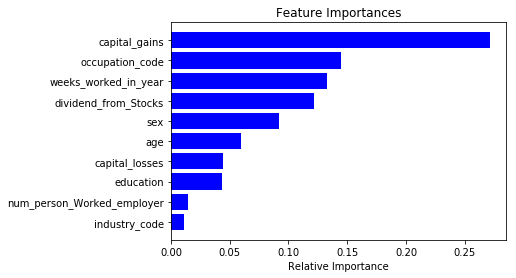

In [18]:
# Checking for important features
df_train = d_train.drop('income_level',1)
model = RandomForestRegressor(random_state=1, max_depth=10)
df_train=pd.get_dummies(df_train)
model.fit(df_train,train.income_level)

features = df_train.columns
importances = model.feature_importances_
indices = np.argsort(importances)[-10:]  # top 10 features
plt.title('Feature Importances')
plt.barh(range(len(indices)), importances[indices], color='b', align='center')
plt.yticks(range(len(indices)), [features[i] for i in indices])
plt.xlabel('Relative Importance')
plt.show()

# Taking top 10 features for the model
d_train_imp = d_train.loc[:,['industry_code', 'num_person_Worked_employer', 'education',
       'capital_losses', 'age', 'sex', 'dividend_from_Stocks',
       'weeks_worked_in_year', 'occupation_code', 'capital_gains','income_level']]

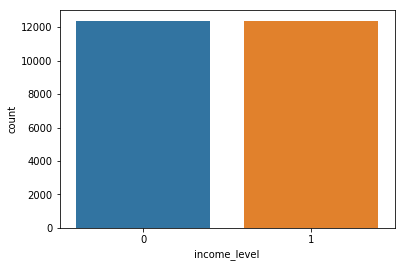

In [19]:
# Sampling Techniques

# 1. Undersampling 

# finding no. of samples which are >50K
more_50k = len(d_train[d_train['income_level'] == 1])

# getting indices of <50k records
less_50k_indices = d_train[d_train.income_level == 0].index

# getting random sample from <50k indices
random_indices = np.random.choice(less_50k_indices,more_50k, replace=False)

# finding indices of >50k samples
more_50k_indices = d_train[d_train.income_level == 1].index

# Concatinating more than 50k & random less than 50k samples
under_sample_indices = np.concatenate([more_50k_indices,random_indices])

# Getting the dataframe for the above . Here the income levle is evenly disrtibuted.
under_sample = d_train.loc[under_sample_indices]

sns.countplot('income_level',data=under_sample)

In [12]:
# Running Logistic Regression on undersampled(balanced) data
from sklearn.model_selection import train_test_split
from sklearn import cross_validation,metrics
from sklearn.metrics import accuracy_score,recall_score,confusion_matrix
from sklearn.linear_model import LogisticRegression

X_under = under_sample.loc[:,under_sample.columns != 'income_level']
y_under = under_sample.loc[:,under_sample.columns == 'income_level']
X_under_train, X_under_test, y_under_train, y_under_test = train_test_split(X_under,y_under,test_size = 0.3, random_state = 0)

alg = LogisticRegression()
alg.fit(X_under_train,y_under_train)
y_under_pred = alg.predict(X_under_test)

recall_score(y_under_test,y_under_pred) , accuracy_score(y_under_test,y_under_pred),confusion_matrix(y_under_test,y_under_pred)
# (0.8764044943820225, 0.8524899057873486), array([[3058,  634],[ 462, 3276]], dtype=int64))

(0.8734617442482611, 0.8495289367429341, array([[3047,  645],
        [ 473, 3265]], dtype=int64))

In [20]:
# Logistic Regression using weights on the unbalanced data set
X = d_train_imp.loc[:,d_train_imp.columns != 'income_level']
y = d_train_imp.loc[:,d_train_imp.columns == 'income_level']
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size = 0.3, random_state = 0)

alg = LogisticRegression(class_weight = 'balanced')
alg.fit(X_train,y_train)
y_pred = alg.predict(X_test)

recall_score(y_test,y_pred) , accuracy_score(y_test,y_pred) , confusion_matrix(y_test,y_pred)
# (0.8726519337016575, 0.8201379955560754, array([[45932, 10305],[  461,  3159]], dtype=int64))

(0.8726519337016575, 0.8201379955560754, array([[45932, 10305],
        [  461,  3159]], dtype=int64))

In [24]:
# Oversampling with SMOTE
from imblearn.over_sampling import SMOTE
from sklearn.naive_bayes import GaussianNB

X = d_train_imp.loc[:,d_train_imp.columns != 'income_level']
y = d_train_imp.loc[:,d_train_imp.columns == 'income_level']
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size = 0.3, random_state = 0,stratify=y)

sm = SMOTE(random_state=2)
X_train_res, y_train_res = sm.fit_sample(X_train,y_train)

alg = LogisticRegression()
alg.fit(X_train_res,y_train_res)
y_pred = alg.predict(X_test)

recall_score(y_test,y_pred) , accuracy_score(y_test,y_pred) , confusion_matrix(y_test,y_pred)
# (0.878600269179004, 0.8241475516648011, array([[46067, 10075], [  451,  3264]], dtype=int64))

(0.878600269179004, 0.8241475516648011, array([[46067, 10075],
        [  451,  3264]], dtype=int64))

In [25]:
# Near Miss
from imblearn.under_sampling import NearMiss

X = d_train_imp.loc[:,d_train_imp.columns != 'income_level']
y = d_train_imp.loc[:,d_train_imp.columns == 'income_level']
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size = 0.3, random_state = 0,stratify=y)

sm = NearMiss()
X_train_res, y_train_res = sm.fit_sample(X_train,y_train)

alg = LogisticRegression()
alg.fit(X_train_res,y_train_res)
y_pred = alg.predict(X_test)

recall_score(y_test,y_pred) , accuracy_score(y_test,y_pred) , confusion_matrix(y_test,y_pred)
# (0.9109017496635262, 0.42735185525502445, array([[22196, 33946], [  331,  3384]], dtype=int64))

(0.9109017496635262, 0.42735185525502445, array([[22196, 33946],
        [  331,  3384]], dtype=int64))